<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/protests_visualisation_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spatial graph and data analisis

In [34]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
from datetime import datetime

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 8)

In [35]:
#from google.colab import files
#uploaded = files.upload()

In [36]:
df = pd.read_excel("/content/Copy support-local-authority-datasets-sep-2025.xlsx",
                   sheet_name="2025",
                   engine='openpyxl')
df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...


In [37]:
!pip install pgeocode

import pgeocode
geo = pgeocode.Nominatim("gb")

In [38]:
df["postcode"] = (
    df["postcode"]
    .astype(str)
    .str.upper()
    .str.strip()
)

In [39]:
df.loc[df["postcode"] == "B11BD", "postcode"] = "B1 1BD"

In [40]:
df.loc[df["postcode"] == "1 1JW", "postcode"] = "L1 1JW"

In [41]:
coords = df["postcode"].apply(geo.query_postal_code)

df["latitude"] = coords["latitude"]
df["longitude"] = coords["longitude"]

df.head()

,event_id,date,location_name,town_city,postcode,description,wiki ref,source_url,latitude,longitude
0,U0011,2025-08-08,Hotel protest and counter-protest,Liverpool,L1 1JW,Two groups faced off at a hotel; some counter-...,124,https://news.sky.com/story/migrant-protesters-...,53.41060,-2.977900
1,E0060,2025-09-06,Protest,Aberdeen,AB10 1BL,Arrest reported as protesters gathered.,193,https://www.pressandjournal.co.uk/fp/news/6845...,57.14370,-2.098100
2,E0036,2025-08-02,Demonstration outside accommodation,Aberdeen,AB25 1XF,Arrests/charges under Hate Crime Act reported.,102,https://www.bbc.co.uk/news/articles/cy8jde62697o,57.14370,-2.098100
3,E0004,2025-05-17,City centre march → Victoria Square,Birmingham,B1 1BD,Britain First supporters marched; council said...,49,https://www.birminghammail.co.uk/news/midlands...,52.48140,-1.899800
4,E0048,2025-08-15,Asylum hotel protest,Sutton Coldfield,B76 1LH,Protest at asylum hotel reported.,136,https://www.birminghammail.co.uk/news/midlands...,52.54015,-1.752717


In [42]:
df = df.dropna(subset=["latitude", "longitude"])
print("Remaining events:", len(df))


Remaining events: 126


In [43]:
city_coords = (
    df.groupby("town_city")[["latitude", "longitude"]]
      .mean()
      .reset_index()
)

city_coords.head()

,town_city,latitude,longitude
0,Aberdeen,57.14370,-2.098100
1,Altrincham,53.38524,-2.365540
2,Ashford,51.15110,0.890813
3,Barnwood (Gloucester),51.82706,-2.187810
4,Basingstoke,51.26250,-1.087100


In [44]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

In [45]:
import networkx as nx

G = nx.Graph()

# Add nodes with coordinates
for _, row in city_coords.iterrows():
    G.add_node(
        row["town_city"],
        lat=row["latitude"],
        lon=row["longitude"]
    )

In [46]:
threshold_km = 100

for i, r1 in city_coords.iterrows():
    for j, r2 in city_coords.iterrows():
        if i < j:
            d = haversine(
                r1.latitude, r1.longitude,
                r2.latitude, r2.longitude
            )
            if d <= threshold_km:
                G.add_edge(r1.town_city, r2.town_city, distance=d)

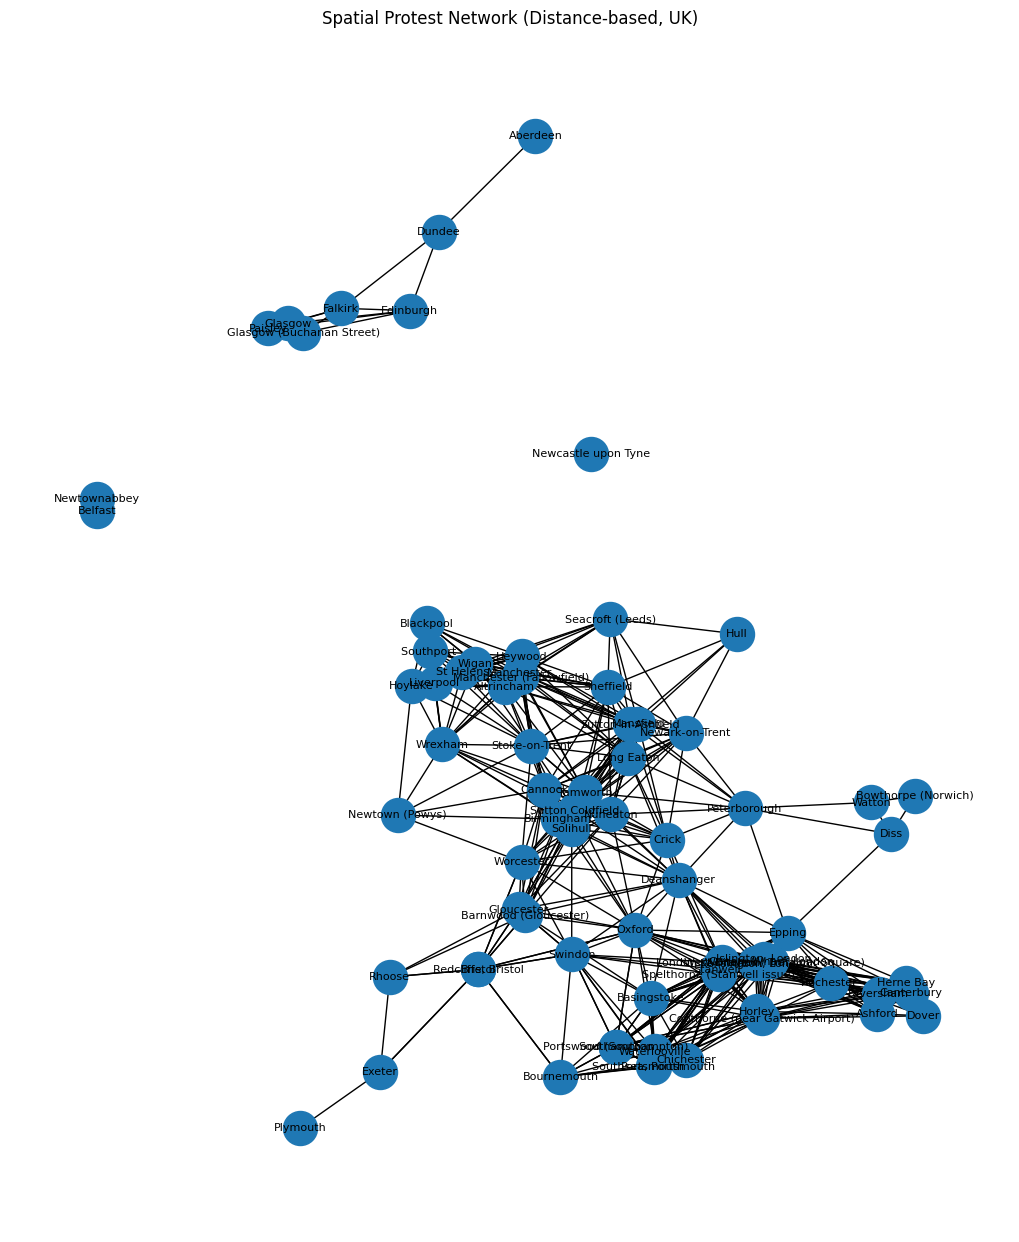

In [47]:
plt.figure(figsize=(10, 12))

pos = {
    n: (G.nodes[n]["lon"], G.nodes[n]["lat"])
    for n in G.nodes()
}

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=600,
    font_size=8
)

plt.title("Spatial Protest Network (Distance-based, UK)")
plt.show()

In [48]:
!rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `rm /content/LAD_MAY_2025_UK_BFC_V2_481919774574330966 (1).geojson'


In [62]:
import geopandas as gpd

uk_map = gpd.read_file("/content/Local_Authority_Districts_May_2024_Boundaries_UK_BGC_-6307115499537197728.geojson")
uk_map.head()

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E06000001,Hartlepool,,447161,531473,-1.27017,54.67613,8d37e356-5471-457e-879d-d687d4dcd9b5,"MULTIPOLYGON (((-1.22459 54.62418, -1.22457 54..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,30eaef71-04d1-4d40-a8da-8a4e2e7e0891,"MULTIPOLYGON (((-1.27712 54.54791, -1.2772 54...."
2,3,E06000003,Redcar and Cleveland,,464330,519596,-1.00656,54.56752,a345a607-6a7e-41bd-a268-81e3741ddc76,"MULTIPOLYGON (((-1.20098 54.57763, -1.20037 54..."
3,4,E06000004,Stockton-on-Tees,,444940,518179,-1.30664,54.55687,d1db01d0-100b-4619-b606-f1208ff4c8cb,"MULTIPOLYGON (((-1.27493 54.55187, -1.27546 54..."
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,c2cc315b-a5c5-497c-8aa4-2994a4d4820b,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495..."


In [50]:
!ls /content

'Copy support-local-authority-datasets-sep-2025.xlsx'
 Local_Authority_Districts_May_2024_Boundaries_UK_BGC_-6307115499537197728.geojson
 sample_data


In [51]:
uk_map = uk_map.to_crs("EPSG:4326")

In [52]:
from shapely.geometry import Point
import pandas as pd

city_df = pd.DataFrame({
    "city": list(G.nodes()),
    "latitude": [G.nodes[n]["lat"] for n in G.nodes()],
    "longitude": [G.nodes[n]["lon"] for n in G.nodes()]
})

geometry = [Point(xy) for xy in zip(city_df["longitude"], city_df["latitude"])]
city_gdf = gpd.GeoDataFrame(city_df, geometry=geometry, crs="EPSG:4326")

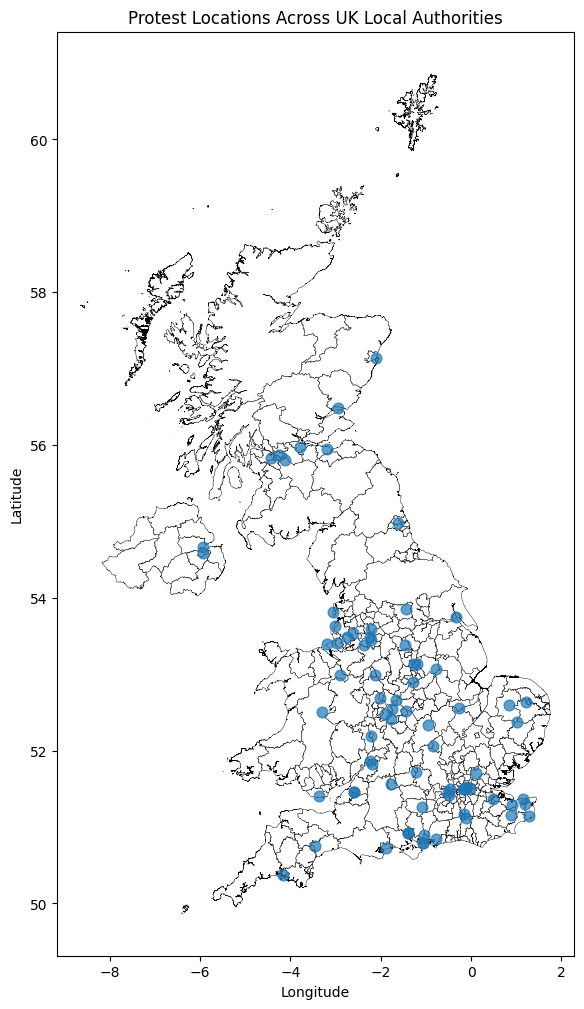

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))

# Plot local authority boundaries
uk_map.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.3
)

# Plot protest city points
city_gdf.plot(
    ax=ax,
    markersize=60,
    alpha=0.7
)

ax.set_title("Protest Locations Across UK Local Authorities")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [54]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from lat/lon
geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [55]:
uk_map = uk_map.to_crs(epsg=4326)

In [56]:
gdf_with_la = gpd.sjoin(
    gdf,
    uk_map,
    how="left",
    predicate="within"
)

uk_map.columns

Index(['FID', 'LAD24CD', 'LAD24NM', 'LAD24NMW', 'BNG_E', 'BNG_N', 'LONG',
       'LAT', 'GlobalID', 'geometry'],
      dtype='object')

In [63]:
gdf_with_la["local_authority"] = gdf_with_la["LAD24NM"]

In [72]:
#gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD25CD"]].head()
protests_df = gdf_with_la[["event_id", "town_city", "postcode", "local_authority", "LAD24CD","date"]]

#rename the columns to make things easier later
protests_df = protests_df.rename(columns={
    "LAD24CD": "lad_code",
})

protests_df.head()

,event_id,town_city,postcode,local_authority,lad_code,date
0,U0011,Liverpool,L1 1JW,Liverpool,E08000012,2025-08-08
1,E0060,Aberdeen,AB10 1BL,Aberdeen City,S12000033,2025-09-06
2,E0036,Aberdeen,AB25 1XF,Aberdeen City,S12000033,2025-08-02
3,E0004,Birmingham,B1 1BD,Birmingham,E08000025,2025-05-17
4,E0048,Sutton Coldfield,B76 1LH,Birmingham,E08000025,2025-08-15


In [82]:
#in protests_df, how many times is each lad_code mentioned?
protests_df["lad_code"].value_counts()
#create a new df called protests_counts where the columns are local_authority values and rows are each assocaited event_id and date from protests_df
protests_counts = protests_df.groupby(["local_authority", "lad_code"]).size().reset_index(name="protests_count")
protests_counts
#sort table by count
protests_counts = protests_counts.sort_values(by="protests_count", ascending=False)
protests_counts

,local_authority,lad_code,protests_count
18,Epping Forest,E07000072,14
10,"Bristol, City of",E06000023,6
59,Tower Hamlets,E09000030,4
42,Portsmouth,E06000044,4
66,Wirral,E08000015,4
...,...,...,...
61,Vale of Glamorgan,W06000014,1
64,Wigan,E08000010,1
65,Winchester,E07000094,1
67,Worcester,E07000237,1


In [87]:
#in protests_df, create quartiles out of the dates

#convert the date column
protests_df["date"] = pd.to_datetime(df["date"], errors="coerce")

#create proper quarterly time variable
protests_df["year_quarter"] = protests_df["date"].dt.to_period("Q")

#find counts of protests in each year_quarter
protests_df["year_quarter"].value_counts()

#find counts of the protests in each month
protests_df["date"].dt.month.value_counts()
#plot the counts of protests in each month of 2025
protests_df[protests_df["date"].dt.year == 2025]["date"].dt.month
#make a plot


,count
date,
8,60
9,23
7,21
10,15
4,3
5,2
11,2


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

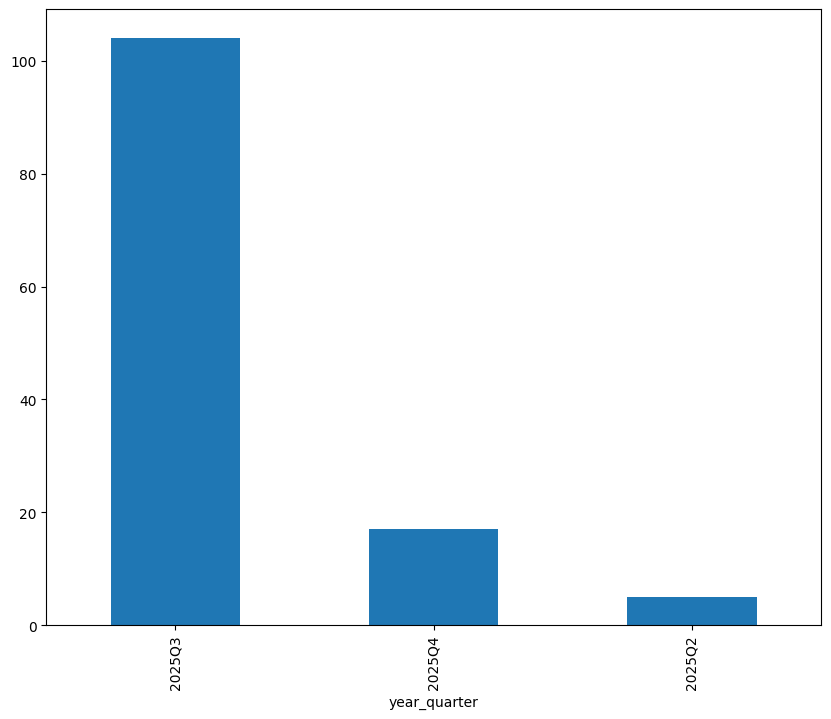

In [86]:
#plot monthly protests over time
protests_df["date"].dt.month



In [66]:
protests_df.dtypes

,0
event_id,object
town_city,object
postcode,object
local_authority,object
lad_code,object


In [67]:

#change the data types accordingly so we can work with the data usign pandas
protests_df['event_id']=protests_df['event_id'].astype('string')
protests_df['town_city']=protests_df['town_city'].astype('category')
protests_df['postcode']=protests_df['postcode'].astype('category')
protests_df['local_authority']=protests_df['local_authority'].astype('category')

In [69]:
import pandas as pd

pop_df = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    sheet_name="population_per_LA",
    header=0,
    engine="openpyxl"
)
pop_df.head()

,lad_code,name,geography,population,Isy
0,E07000223,Adur,Non-metropolitan District,64889,True
1,E07000032,Amber Valley,Non-metropolitan District,130451,True
2,E07000224,Arun,Non-metropolitan District,170064,True
3,E07000170,Ashfield,Non-metropolitan District,129572,True
4,E07000105,Ashford,Non-metropolitan District,140936,True


In [70]:
pop_df.columns
pop_df["lad_code"].nunique()


314

In [79]:
la_exposure = pd.read_excel(
    "/content/Copy support-local-authority-datasets-sep-2025.xlsx",
    engine="openpyxl",
    sheet_name="la_exposure_table",
    header=0,
)
la_exposure.head()

,lad_code,local_authority,population,total_asylum,contingency_per_1000,contingency_share,delta_contingency_Q1_Q3
0,S12000033,Aberdeen City,NaN,624,NaN,0.083333,85.0
1,S12000033,Aberdeen City,NaN,624,NaN,0.533654,85.0
2,S12000034,Aberdeenshire,NaN,358,NaN,0.131285,82.0
3,S12000034,Aberdeenshire,NaN,358,NaN,0.796089,82.0
4,N09000001,Antrim and Newtownabbey,NaN,165,NaN,0.121212,-8.0
